# **Data Visualisation**

---

## Objectives

* The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherryleaves_dataset/train
* inputs/cherryleaves_dataset/validate
* inputs/cherryleaves_dataset/test

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model (creation and training).
* Save model.
* Learning curve plot for model performance.
* Save model evaluation on pkl file.
* Prediction on the random image file.

## Additional Comments

* ADD COMMENTS!

---

# Change working directory

We need to change the working directory from its current folder, to its parent folder.

In [4]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/portfolio-five/jupyter_notebooks'

We want to make the parent of the current directory, our new working directory.

In [5]:
os.chdir(os.path.dirname(current_dir))
print("You have successfully set a new working directory")

You have successfully set a new working directory


And finally, confirm our new working directory.

In [6]:
current_dir = os.getcwd()
current_dir

'/workspaces/portfolio-five'

---

# Preparing the workspace

First we set our input directories using our train, test and validation paths.

In [14]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set our output directory and a version number.

In [15]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


Set our label names.

In [16]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


Set our image shape.

In [17]:
import joblib
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

And import the packages needed for this notebook.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.image import imread


KeyboardInterrupt



---

# Image distribution

We will count the number of images per set and per label, then plot them to  bar chart.

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




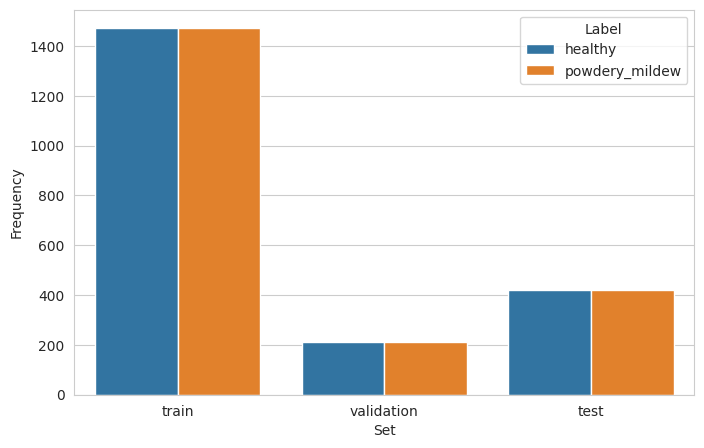

In [9]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

We will import the keras image data generator.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Then initialize the image data generator and set our batch size.

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [20]:
batch_size = 20

Firstly, we will augment the training image data set.

In [13]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Then augment our validation image data set.

In [14]:
validation_set = augmented_image_data.flow_from_directory(val_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

And lastly augment our test image data set.

In [21]:
test_set = augmented_image_data.flow_from_directory(test_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

---

# Plot augmented image sets

We can view our augmented training image set.

In [ ]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

As well as the augmented validation image set.

In [ ]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

And view our augmented test image set.

In [ ]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

Then save our class_indices as a pkl file.

In [ ]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

---

# Model creation

Import model packages

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Create model

In [23]:
def create_tf_model():
    model = Sequential()
    
    # input layer
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    
    # convolutional layers
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())

    # fully connected layer
    model.add(Dense(256, activation='relu'))

    # output
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

Model Summary

In [24]:
create_tf_model().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 14400)            

Early Stopping

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

Fit model for model training

In [26]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-01-11 16:51:27.714606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 279s 1s/step - loss: 0.3053 - accuracy: 0.8642 - val_loss: 0.0798 - val_accuracy: 0.9714
Epoch 2/25
147/147 [==============================] - 217s 1s/step - loss: 0.0472 - accuracy: 0.9829 - val_loss: 0.0996 - val_accuracy: 0.9524
Epoch 3/25
147/147 [==============================] - 212s 1s/step - loss: 0.0297 - accuracy: 0.9894 - val_loss: 0.0094 - val_accuracy: 0.9952
Epoch 4/25
147/147 [==============================] - 205s 1s/step - loss: 0.0465 - accuracy: 0.9846 - val_loss: 0.0371 - val_accuracy: 0.9786
Epoch 5/25
147/147 [==============================] - 212s 1s/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0244 - val_accuracy: 0.9905
Epoch 6/25
147/147 [==============================] - 212s 1s/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 7/25
147/147 [==============================] - 208s 1s/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0015 - val_accuracy: 1.0000

Save model

In [27]:
model.save('outputs/v1/powdery_mildew_model.h5')

---

# Model performance and evalutaion

To evaluate model performance we can plot the loss and validation loss.

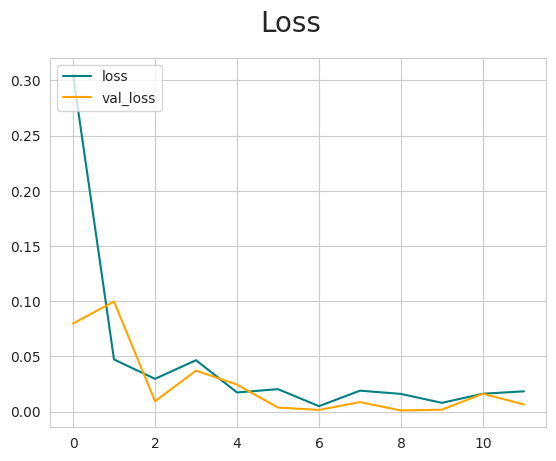

In [30]:
fig = plt.figure()
plt.plot(model.history.history['loss'], color='teal', label='loss')
plt.plot(model.history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

And also, plot the accuracy and validation accuracy.

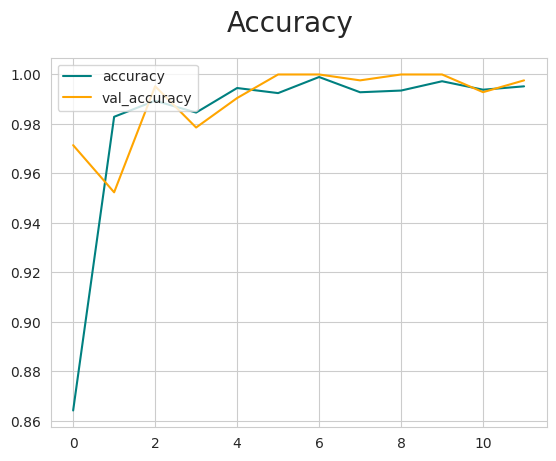

In [32]:
fig = plt.figure()
plt.plot(model.history.history['accuracy'], color='teal', label='accuracy')
plt.plot(model.history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

To continue our model evaluation we will load our model.

In [7]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.h5')

2024-01-16 17:15:57.720807: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluate our model, based on our test set.

In [22]:
evaluation = model.evaluate(test_set)

2024-01-16 17:21:25.391000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


43/43 [==============================] - 188s 3s/step - loss: 0.0043 - accuracy: 0.9988


And save our evaluation as a pkl file.

In [23]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

Then we will check our model can predict using new data, by importing a random image as PIL.

Image shape: (256, 256), Image mode: RGB


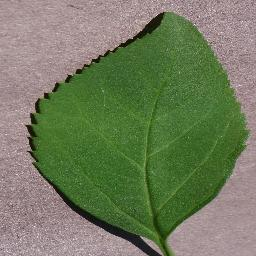

In [24]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert the image to a tensor array and prepare for prediction.

In [25]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Then print the probability of a correct class prediction.

In [ ]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

---

# Push files to repository.

Git add

In [ ]:
!git add .

Git commit

In [ ]:
!git commit -m "Commit message"

Git push

In [ ]:
!git push

---

# Model is now trained and can be used to predict. Congratulations!